In [1]:
import os
from pathlib import Path
import librosa
import re
from time import time
import ast
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from IPython.display import Audio, display
import soundfile as sf
from scipy.io import wavfile

from src.utils.SpectrogramExtractor import SpectrogramExtractor         # Custom class to create a spectrogram from a .wav

In [2]:
def plot_spectrograms_from_paths(spec_paths, df, hop_ms=10):
    """
    Vertically stacked spectrograms with shared x-axis. Only bottom plot shows axis labels.

    Args:
        spec_paths (list): List of full paths to spectrogram .pt files.
        df (pd.DataFrame): DataFrame with 'spec_dir' and 'speaker_count' columns.
        hop_ms (int): Hop size in milliseconds for time axis calculation.
    """
    n_clips = len(spec_paths)
    fig, axes = plt.subplots(n_clips, 1, figsize=(5, 1.75 * n_clips), sharex=True)

    for idx, (spec_path, ax) in enumerate(zip(spec_paths, axes)):
        spectrogram = torch.load(spec_path).squeeze()

        # Lookup speaker count
        match = df.loc[df['spec_dir'] == spec_path, 'speaker_count']
        speaker_count = match.values[0] if not match.empty else 'Unknown'

        # Time axis
        n_frames = spectrogram.shape[1]
        duration_sec = (n_frames * hop_ms) / 1000

        # Plot
        im = ax.imshow(spectrogram.numpy(), aspect='auto', origin='lower',
                       extent=[0, duration_sec, 0, spectrogram.shape[0]],
                       cmap='magma')

        ax.set_title(f'Speaker Count: {speaker_count}', fontsize=11)

        # Y-axis cleanup
        ax.set_ylabel(
        "(Hz)",    
        rotation=0,            
        labelpad=12,
        va="center" 
        )

        ax.set_yticks([])

        # X-axis formatting
        if idx < n_clips - 1:
            ax.tick_params(axis='x', labelbottom=False)  # Show ticks, hide labels
        else:
            ax.set_xlabel('Time (s)')

    fig.tight_layout()
    cbar = fig.colorbar(im, ax=axes, location='right', shrink=0.6)

    # Set custom ticks: first, middle, last
    cbar_ticks = [im.norm.vmin, (im.norm.vmin + im.norm.vmax) / 2, im.norm.vmax]
    cbar.set_ticks(cbar_ticks)
    cbar.set_ticklabels(['-', '0', '+'])

    # Optional: label
    cbar.set_label('Amplitude', rotation=270, labelpad=15)

    plt.show()

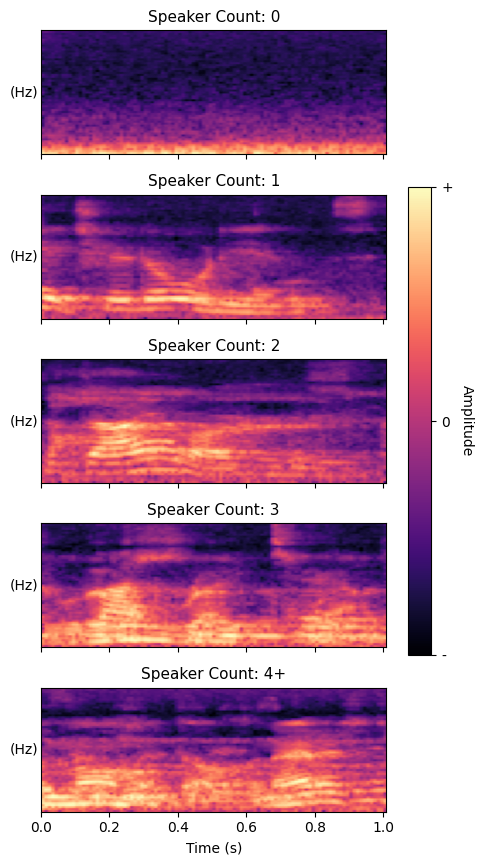

In [4]:
spec_paths = [
     r'data\specs_rir\largeroom1_1_clip1.pt',
     r'data\specs_libricss\0L_session0_clip28.pt',
    r'data\specs_aug\overlay_1.pt',
    r'data\specs_aug\overlay_25500.pt',
    r'data\specs_aug\overlay_52500.pt'
]

plot_spectrograms_from_paths(spec_paths, df = pd.read_csv(r'data/labels/final_labels.csv'))

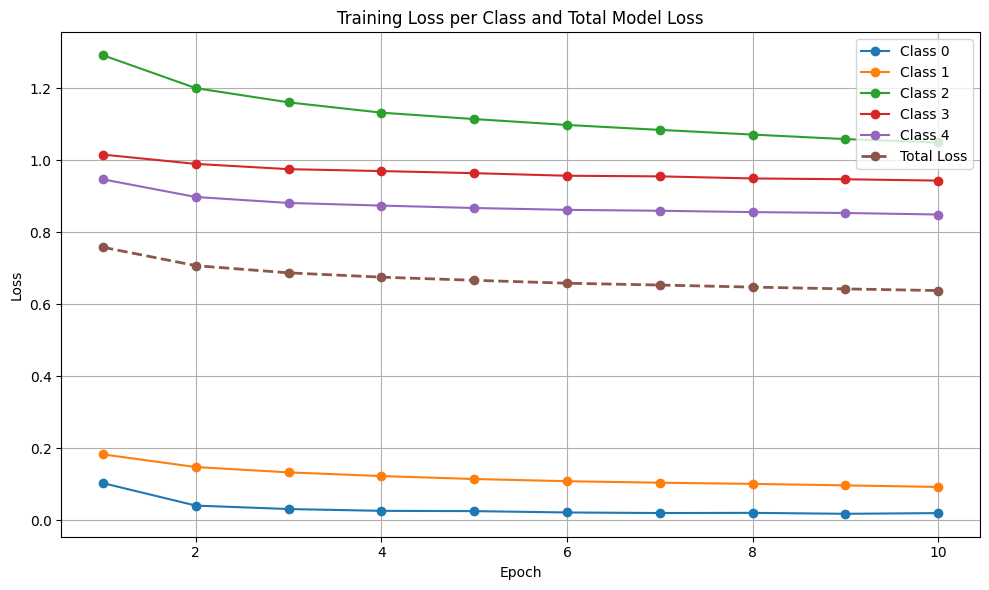

In [5]:
import matplotlib.pyplot as plt

# Epochs
epochs = list(range(1, 11))

# Per-class losses over epochs
loss_class_0 = [0.1034, 0.0410, 0.0314, 0.0264, 0.0256, 0.0219, 0.0203, 0.0208, 0.0182, 0.0201]
loss_class_1 = [0.1832, 0.1481, 0.1333, 0.1230, 0.1149, 0.1087, 0.1046, 0.1013, 0.0972, 0.0928]
loss_class_2 = [1.2923, 1.2009, 1.1614, 1.1328, 1.1150, 1.0986, 1.0849, 1.0719, 1.0593, 1.0499]
loss_class_3 = [1.0163, 0.9904, 0.9758, 0.9705, 0.9647, 0.9575, 0.9558, 0.9500, 0.9478, 0.9440]
loss_class_4 = [0.9475, 0.8985, 0.8819, 0.8746, 0.8679, 0.8627, 0.8602, 0.8565, 0.8540, 0.8498]

# Total model loss
total_loss = [0.7588, 0.7077, 0.6877, 0.6757, 0.6670, 0.6589, 0.6538, 0.6481, 0.6431, 0.6385]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_class_0, label='Class 0', marker='o')
plt.plot(epochs, loss_class_1, label='Class 1', marker='o')
plt.plot(epochs, loss_class_2, label='Class 2', marker='o')
plt.plot(epochs, loss_class_3, label='Class 3', marker='o')
plt.plot(epochs, loss_class_4, label='Class 4', marker='o')
plt.plot(epochs, total_loss, label='Total Loss', marker='o', linestyle='--', linewidth=2)

plt.title('Training Loss per Class and Total Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## What does the loss plot above suggest?
It suggests that the model is inadequately complex to learn the decision boundary of the higher classes. 